## Utility

In [1]:
import matplotlib.pyplot as plt
from image_util import I

In [2]:
import copy

def pad_image(image, padding_height, padding_width):
    image = copy.deepcopy(image) # Avoid modifying the original image
    padded_image = []
    rows = len(image)
    cols = len(image[0])
    channels = len(image[0][0]) if type(image[0][0]) == list else 1 

    # Adjust channels
    zeros = [0] * channels
    if (channels == 1):
        zeros = 0

    # Pad rows at the top and bottom
    for i in range(padding_height):
        padded_image.append([zeros] * cols)
    for row in image:
        padded_image.append(row)
    for i in range(padding_height):
        padded_image.append([zeros] * cols)

    # Pad columns at the left and right
    for i in range(len(padded_image)):
        for j in range(padding_width):
            padded_image[i].insert(0, zeros)
        for j in range(padding_width):
            padded_image[i].append(zeros)

    return copy.deepcopy(padded_image)

In [3]:
import copy

def convolution(image, kernel):
    '''
    Performs convolution between an image and a kernel
    '''
    image = copy.deepcopy(image) # Avoid modifying the original image
    
    padding_height = len(kernel) // 2
    padding_width = len(kernel[0]) // 2
    
    # Pad the image
    padded_image = pad_image(image, padding_height, padding_width)
    
    # Create an output matrix with the same dimensions as the input image
    output = [[0] * len(image[0]) for i in range(len(image))]

    # Perform convolution
    image_height = len(image)
    image_width = len(image[0])
    kernel_height = len(kernel)
    kernel_width = len(kernel[0])
    
    for i in range(image_height):
        for j in range(image_width):
            for k in range(kernel_height):
                for l in range(kernel_width):
                    # kernel multiplication
                    if type(padded_image[i + k][j + l]) == list:
                        result = [x * kernel[k][l] for x in padded_image[i + k][j + l]]
                    else: # Assume it's a number
                        result = padded_image[i + k][j + l] * kernel[k][l]
                    output[i][j] = output[i][j] + int(result)
    return output

## Functions

### Gaussian Filter

In [4]:
import math

def generate_gaussian_kernel(size, sigma):
    kernel = [[0.0] * size for _ in range(size)]
    center = size // 2
    total = 0.0

    for i in range(size):
        for j in range(size):
            x = i - center
            y = j - center
            exponent = -(x ** 2 + y ** 2) / (2 * sigma ** 2)
            kernel[i][j] = math.exp(exponent)
            total += kernel[i][j]

    # Normalize the kernel
    for i in range(size):
        for j in range(size):
            kernel[i][j] /= total
            kernel[i][j] = round(kernel[i][j], 2)

    return kernel

def gaussian_blur(image, kernel_size, sigma):
    kernel = generate_gaussian_kernel(kernel_size, sigma)
    return convolution(image, kernel)

### Sobel Operator

In [5]:
def sobel_operator(
    img: list,
    x_kernel: list = [[-1, 0, 1], 
                     [-2, 0, 2], 
                     [-1, 0, 1]],
    y_kernel: list = [[-1, -2, -1],
                      [0, 0, 0],
                      [1, 2, 1]]
    ) -> list:
    '''
    detect edges in an image
    '''
    # convert image to grayscale
    if type(img[0][0]) != int and len(img[0][0]) == 3:
        img = I.to_gray(img)
    
    # calculate the gradient in the x-direction and y-direction
    Ix = convolution(img, x_kernel)
    Iy = convolution(img, y_kernel)
    
    return Ix, Iy

### Gradient Magnitude

In [6]:
def gradient_magnitude(Ix, Iy):
    '''
    calculate the magnitude of the gradient
    '''
    # create edge image
    magnitude = []
    
    # loop through the image
    for i in range(len(img)):
        magnitude.append([])
        for j in range(len(img[0])):
            # remove edge pixels in image boundary
            if i == 0 or i == len(img) - 1 or j == 0 or j == len(img[0]) - 1:
                magnitude[i].append(0)
                continue
            # calculate the gradient magnitude
            magnitude[i].append(int((Ix[i][j]**2 + Iy[i][j]**2)**0.5))
            
    return magnitude

### Gradient Direction

In [7]:
def gradient_direction(Ix, Iy):
    Itheta = []
    for i in range(len(img)):
        Itheta.append([])
        for j in range(len(img[0])):
            Itheta[i].append(int(math.atan2(Iy[i][j], Ix[i][j]) * 180 / math.pi))
            
    return Itheta

### Non-Maximum Suppression

In [8]:
def non_max_supp(Ixy, Itheta):
    h, w = len(img), len(img[0])
    res = [[0] * w for _ in range(h)]
    
    # normalize the gradient direction
    for i in range(h):
        for j in range(w):
            if Itheta[i][j] < 0:
                Itheta[i][j] += 180
    
    for i in range(1, h-1):
        for j in range(1, w-1):
            q, r = 255, 255
            # angle 0
            if (0 <= Itheta[i][j] < 22.5) or (157.5 <= Itheta[i][j] <= 180):
                q = Ixy[i][j+1]
                r = Ixy[i][j-1]
            # angle 45
            elif 22.5 <= Itheta[i][j] < 67.5:
                q = Ixy[i+1][j-1]
                r = Ixy[i-1][j+1]
            # angle 90
            elif 67.5 <= Itheta[i][j] < 112.5:
                q = Ixy[i+1][j]
                r = Ixy[i-1][j]
            # angle 135
            elif 112.5 <= Itheta[i][j] < 157.5:
                q = Ixy[i-1][j-1]
                r = Ixy[i+1][j+1]
                
            # non-maximum suppression
            if (Ixy[i][j] >= q) and (Ixy[i][j] >= r):
                res[i][j] = Ixy[i][j]
            else:
                res[i][j] = 0
                
    return res

### Double Thresholding

In [9]:
def double_threshold(img, low=0.05, high=0.09):
    # get max value of the image
    max_val = max([max(i) for i in img])
    if max_val > 255:
        max_val = 255
    
    high_threshold = max_val * high
    low_threshold = high_threshold * low
    
    h, w = len(img), len(img[0])
    res = [[0] * w for _ in range(h)]
    
    weak = 25
    strong = 255
    
    strong_i, strong_j = [], []
    weak_i, weak_j = [], []
    
    for i in range(h):
        for j in range(w):
            if img[i][j] >= high_threshold:
                res[i][j] = strong
                strong_i.append(i)
                strong_j.append(j)
            elif img[i][j] >= low_threshold:
                res[i][j] = weak
                weak_i.append(i)
                weak_j.append(j)
     
    return res, weak, strong

In [10]:
def hysteresis(img, weak, strong=255):
    img = copy.deepcopy(img)
    h, w = len(img), len(img[0])
    for i in range(1, h-1):
        for j in range(1, w-1):
            if img[i][j] == strong:
                continue
            
            if img[i][j] == weak:
                if (img[i+1][j-1] == strong) or (img[i+1][j] == strong) or (img[i+1][j+1] == strong) or (img[i][j-1] == strong) or (img[i][j+1] == strong) or (img[i-1][j-1] == strong) or (img[i-1][j]) or (img[i-1][j+1] == strong):
                    # if any of the surrounding pixels is strong, then set the pixel to strong
                    img[i][j] = strong
            else:
                img[i][j] = 0
                
    return img

## Implementation

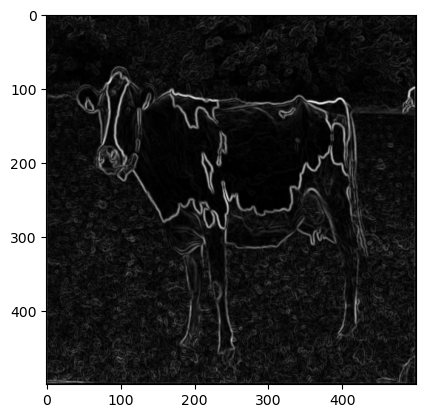

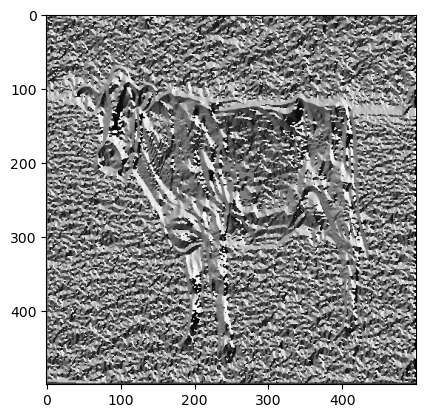

In [11]:
img = I.from_np(plt.imread('data/bg/sapix.jpeg')).image
img = I.bl_resize(img, new_h=500, new_w=500)
gray = I.to_gray(img)
blur = gaussian_blur(gray, 3, 1)
# I.show(blur, gray=True)

Ix, Iy = sobel_operator(blur)

Ixy = gradient_magnitude(Ix, Iy)
I.show(Ixy, gray=True)

Itheta = gradient_direction(Ix, Iy)
I.show(Itheta, gray=True)

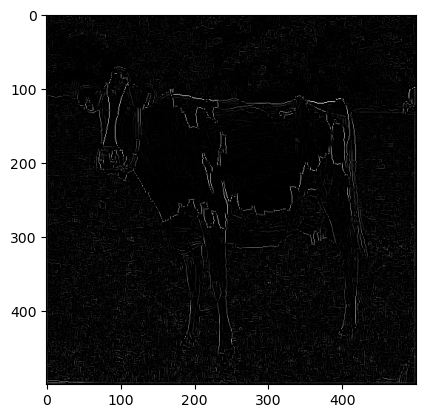

In [12]:
nms = non_max_supp(Ixy, Itheta)
I.show(nms, gray=True)

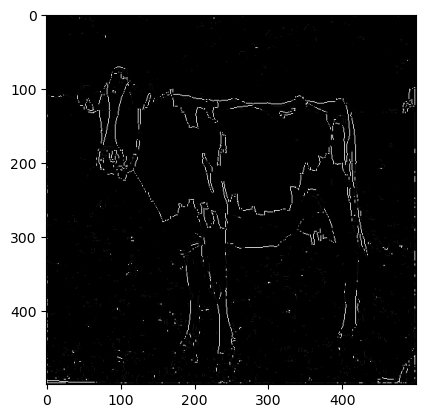

In [13]:
res, weak, strong = double_threshold(nms, 0.65, 0.7)
I.show(res, gray=True)

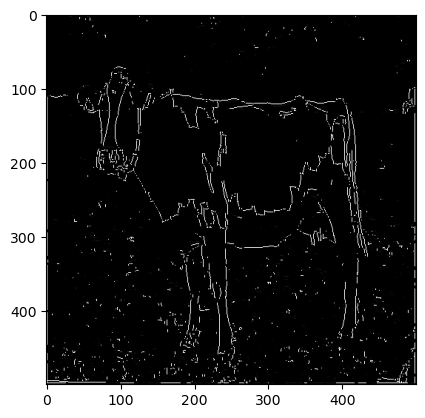

(500, 500)

In [14]:
final = hysteresis(res, weak, strong)
I.show(final, gray=True)
len(final), len(final[0])

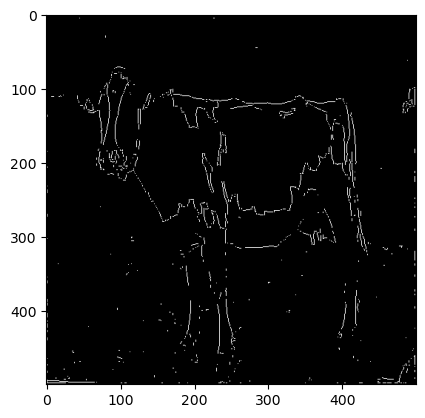

In [15]:
# set weak pixels to 0
def set_weak_to_zero(res, weak):
    img = copy.deepcopy(res)
    for i in range(len(img)):
        for j in range(len(img[0])):
            if img[i][j] == weak:
                img[i][j] = 0
    return img
    
 
strong = set_weak_to_zero(res, weak)
I.show(strong, gray=True)

## Final Function

In [16]:
def edge_detector(img, low=0.05, high=0.09, hyst=True):
    gray = I.to_gray(img)
    blur = gaussian_blur(gray, 3, 1)
    Ix, Iy = sobel_operator(blur)
    Ixy = gradient_magnitude(Ix, Iy)
    Itheta = gradient_direction(Ix, Iy)
    nms = non_max_supp(Ixy, Itheta)
    res, weak, strong = double_threshold(nms, low, high)
    
    if hyst:
        final = hysteresis(res, weak, strong)
    else:
        final = set_weak_to_zero(res, weak)
    
    return final

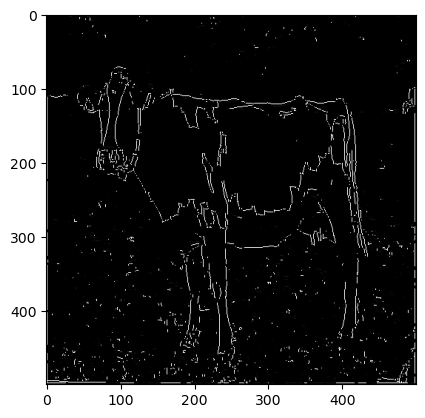

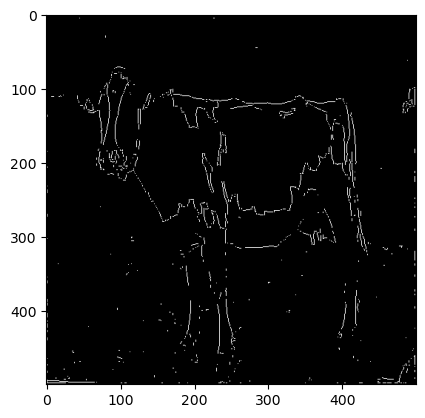

In [17]:
img = I.from_np(plt.imread('data/bg/sapix.jpeg')).image
img = I.bl_resize(img, new_h=500, new_w=500)
edges_hyst = edge_detector(img, 0.65, 0.7)
edges = edge_detector(img, 0.65, 0.7, hyst=False)

I.show(edges_hyst, gray=True)
I.show(edges, gray=True)

In [18]:
from canny_operator import canny_edge_detector

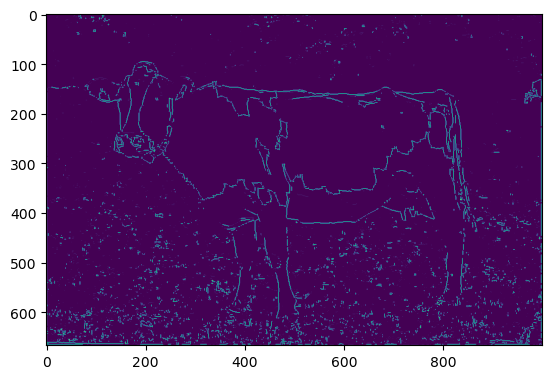

In [19]:
img = I.from_np(plt.imread('data/bg/sapix.jpeg')).image
edge = canny_edge_detector(img=img, low=0.65, high=0.7, hyst=True)

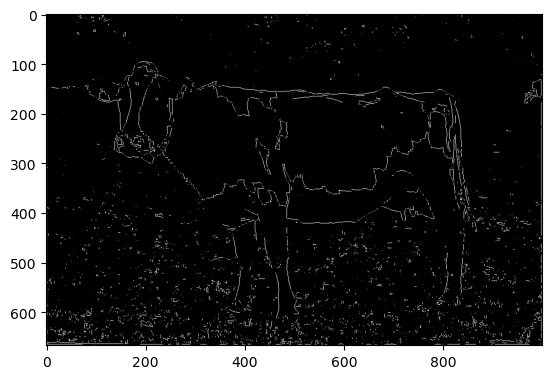

In [20]:
I.show(edge, gray=True)